### QPIXL Extension Demo Notebook

This notebook demonstrates the integration of the following components added to the QPIXL/qiskit module:
- `qpixl_module.py`: A modular interface to create QPIXL-encoded circuits
- `quantum_composer.py`: A flexible system to combine QPIXL data and quantum circuits using composition rules

The tests below cover various integration modes, including image/audio encoding, gate injection, algorithm composition, and hardware-aware transpilation.


In [1]:
!git clone https://github.com/moth-quantum/QuantumArtHack

fatal: destination path 'QuantumArtHack' already exists and is not an empty directory.


In [2]:
%cd QuantumArtHack

/content/QuantumArtHack


In [3]:
!pip install qiskit==2.0.0 matplotlib==3.10.1 pillow==11.1.0 ipywidgets==8.1.5 qiskit-aer==0.17.0 soundfile==0.13.1 pylatexenc==2.10 playsound3==3.2.2

In [4]:
import os
import sys

# Add the current directory (QuantumArtHack) to Python's path
sys.path.append(os.getcwd())

In [5]:
import QPIXL.helper as hlp
from QPIXL.qiskit.qpixl import cFRQI
from QPIXL.qiskit.qpixl_angs import cFRQIangs, decodeAngQPIXL
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator, AerSimulator
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from PIL import Image
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from itertools import chain
import io
import math
# Removed: from scipy.fft import fwht, ifwht # No longer directly import these
from qiskit.circuit.library import QFT
import traceback

import warnings
import soundfile

warnings.filterwarnings("ignore")

backend = StatevectorSimulator(method="statevector")

# Test 1: Sequential Combination — QPIXL and Simple Algorithm
This cell demonstrates the use of the QuantumComposer with the sequential combination rule. **bold text**

-A QPIXL module is created from an 8-pixel grayscale image encoded as rotation angles

-A simple quantum algorithm circuit is defined with a Hadamard and a CNOT

-The two circuits are combined sequentially without entanglement

-The resulting circuit is drawn to verify structure and correctness



▶ Combining using rule: sequential
  ↪ QPIXLModule
  ↪ MyAlgo
✓ Done in 0.00s


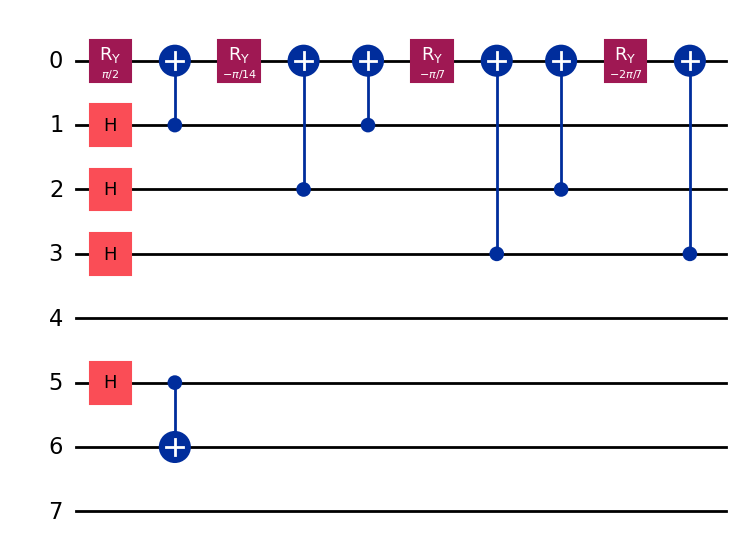

In [6]:
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
from qiskit import QuantumCircuit
import numpy as np

# Setup QPIXL and a small algorithm
image = np.linspace(0, np.pi / 2, 8)
qpixl = QPIXLModule(image)
algo = QuantumCircuit(3); algo.h(0); algo.cx(0, 1)
algo_mod = QiskitCircuitModule(algo, name="MyAlgo")

# Combine sequentially
composer = QuantumComposer([qpixl, algo_mod])
combined = composer.combine(rule="sequential")

# Show
combined.draw("mpl")


# Test 2: Merged Combination with Entanglement
This test uses the merge rule in QuantumComposer to combine a QPIXL module and an algorithm circuit.

*   The QPIXL and algorithm circuits are merged side by side
*   An entangling CZ gate is applied between qubit 0 of the QPIXL circuit and qubit 0 of the algorithm circuit using connection_map={0: 3}

*  The output circuit includes both sub-circuits along with the entanglement gate


▶ Combining using rule: merge
  ↪ QPIXLImg
  ↪ MyAlgo
✓ Done in 0.00s


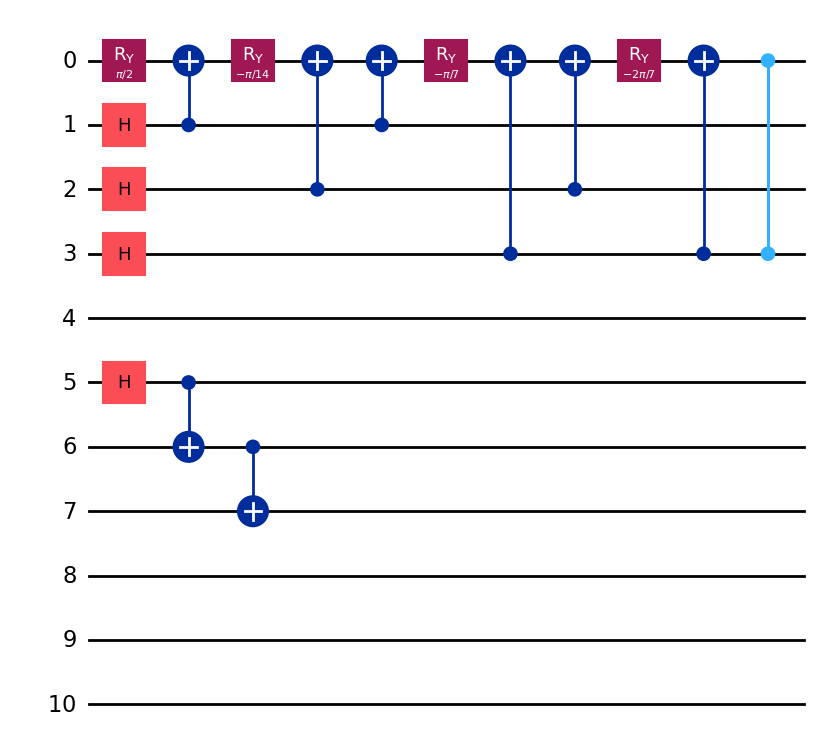

In [24]:
composer = QuantumComposer([qpixl, algo_mod])
merged = composer.combine(
    rule="merge",
    connection_map={0: 3},
    entangle_type="cz"
)
merged.draw("mpl")


# Test 3: Image-Based QPIXL with Compression + Algorithm
In this test, an 8×8 grayscale image is converted into angle-encoded pixel data and encoded using QPIXL with compression enabled.

*   The image is flattened and scaled to angles between 0 and π

*    QPIXL encoding is applied with a compression setting of 30


*   A simple quantum algorithm (Hadamard + two CNOTs) is defined on 6 qubits


*   Both circuits are combined sequentially to form a full quantum circuit



▶ Combining using rule: sequential
  ↪ QPIXLModule
  ↪ MyAlgo
✓ Done in 0.01s


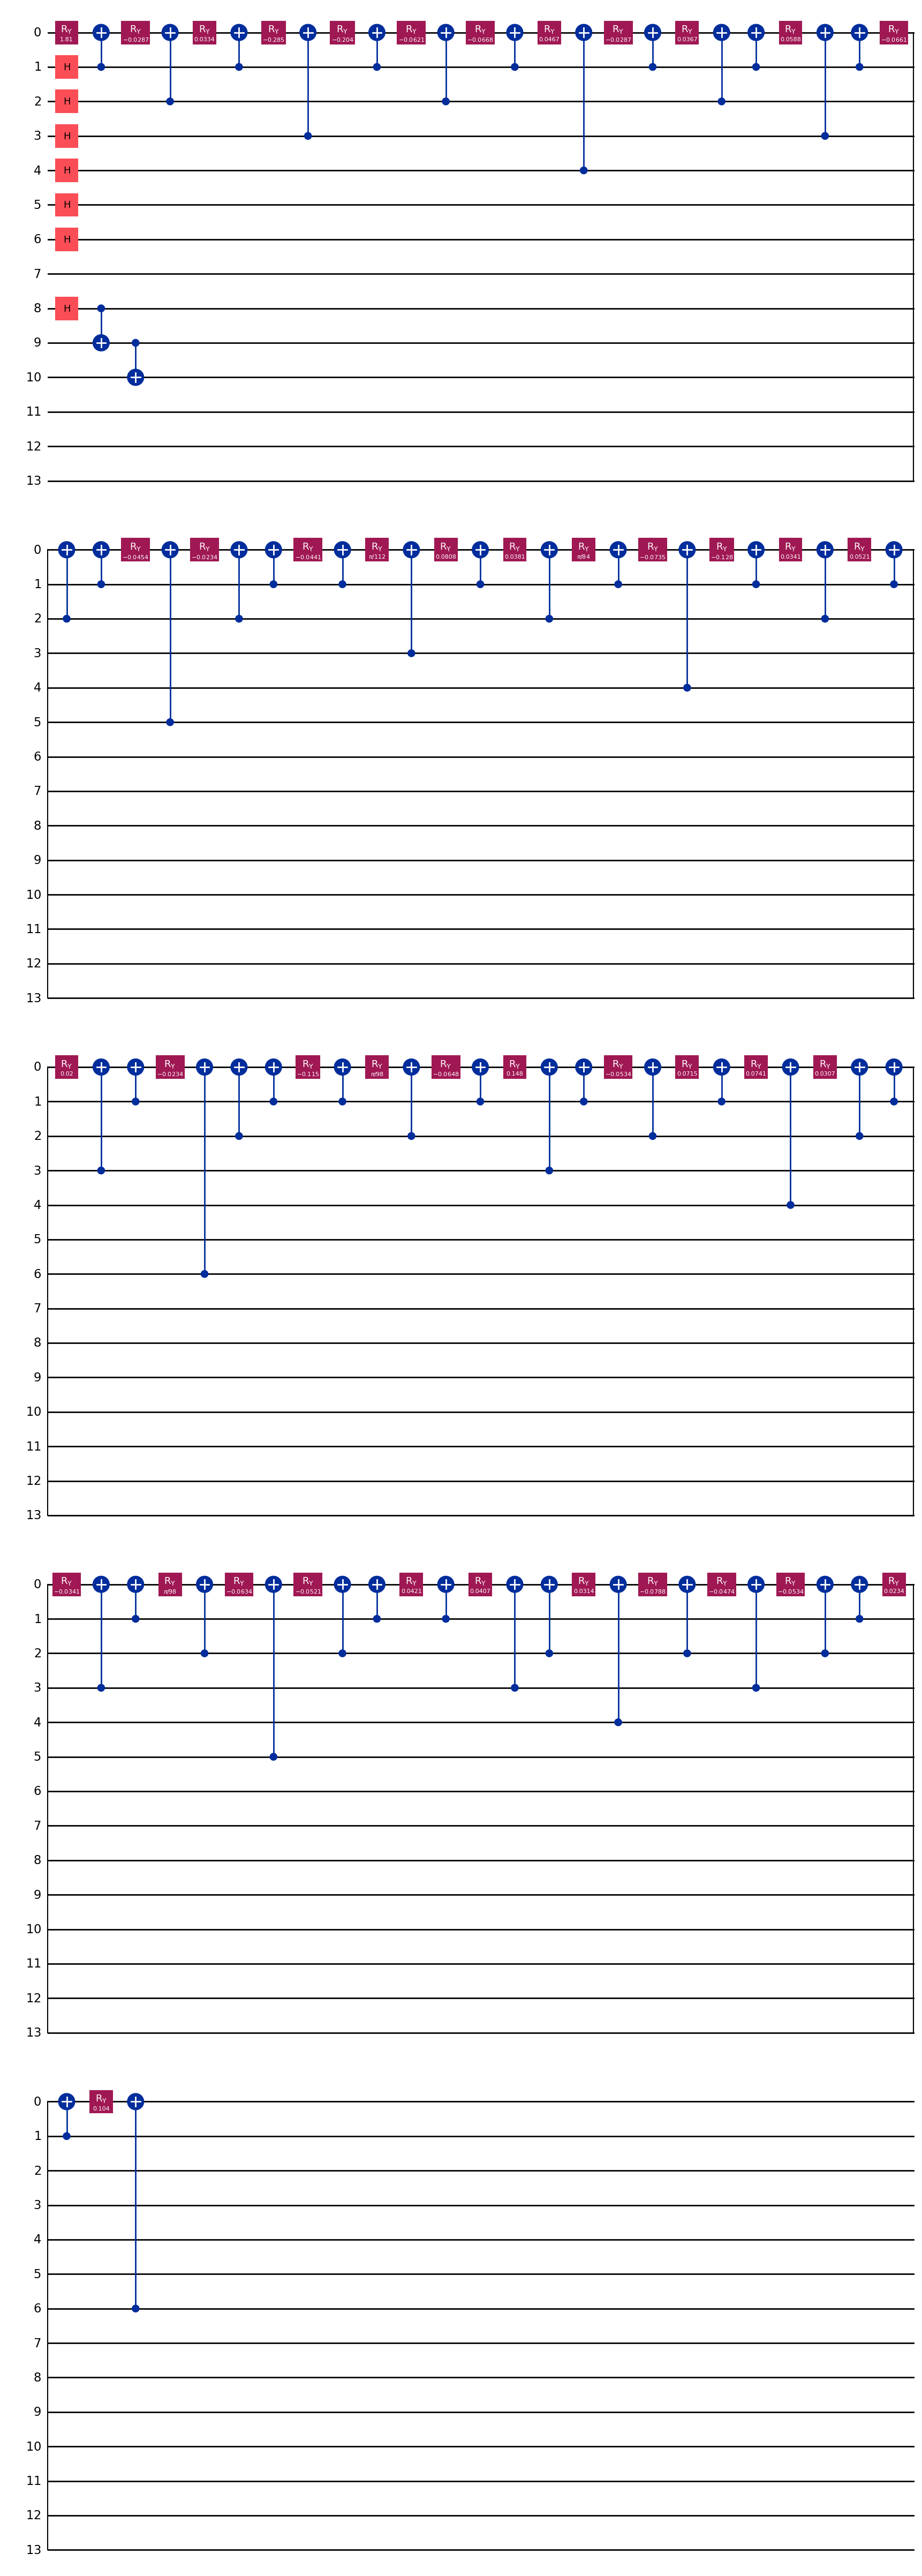

In [23]:
from PIL import Image
import numpy as np
from qiskit import QuantumCircuit
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer

# Load and preprocess the image (8x8)
img = Image.open("/content/QuantumArtHack/figures/cat.webp").convert("L").resize((8, 8))
angles = (np.array(img) / 255.0 * np.pi).flatten()

# QPIXL module (with compression)
qpixl_mod = QPIXLModule(angles, compression=30)

# Add an algorithm module (e.g. simple QFT)
algo = QuantumCircuit(6)
algo.h(0); algo.cx(0, 1); algo.cx(1, 2)
algo_mod = QiskitCircuitModule(algo, name="MyAlgo")

# Compose the system
composer = QuantumComposer([qpixl_mod, algo_mod])
combined = composer.combine(rule="sequential")

# Visualize
combined.draw("mpl")


In [22]:
qpixl_lo = QPIXLModule(angles, compression=0)
qpixl_hi = QPIXLModule(angles, compression=80)

print("Uncompressed depth:", qpixl_lo.get_circuit().depth())
print("Compressed depth:", qpixl_hi.get_circuit().depth())


Uncompressed depth: 32
Compressed depth: 8


# Test 4: RGB QPIXL Encoding and Merge
In this test, a color image is processed by separating its Red, Green, and Blue channels, encoding each independently using QPIXL.

*   The image is resized to 4×4 and split into R, G, B components.
Each channel is scaled to rotation angles and flattened

*   Separate QPIXL modules are created for each color with compression
*   The modules are combined side-by-side using the merge rule


*  This demonstrates how QPIXL and QuantumComposer can support multi-channel data



▶ Combining using rule: merge
  ↪ RedChannel
  ↪ GreenChannel
  ↪ BlueChannel
✓ Done in 0.01s


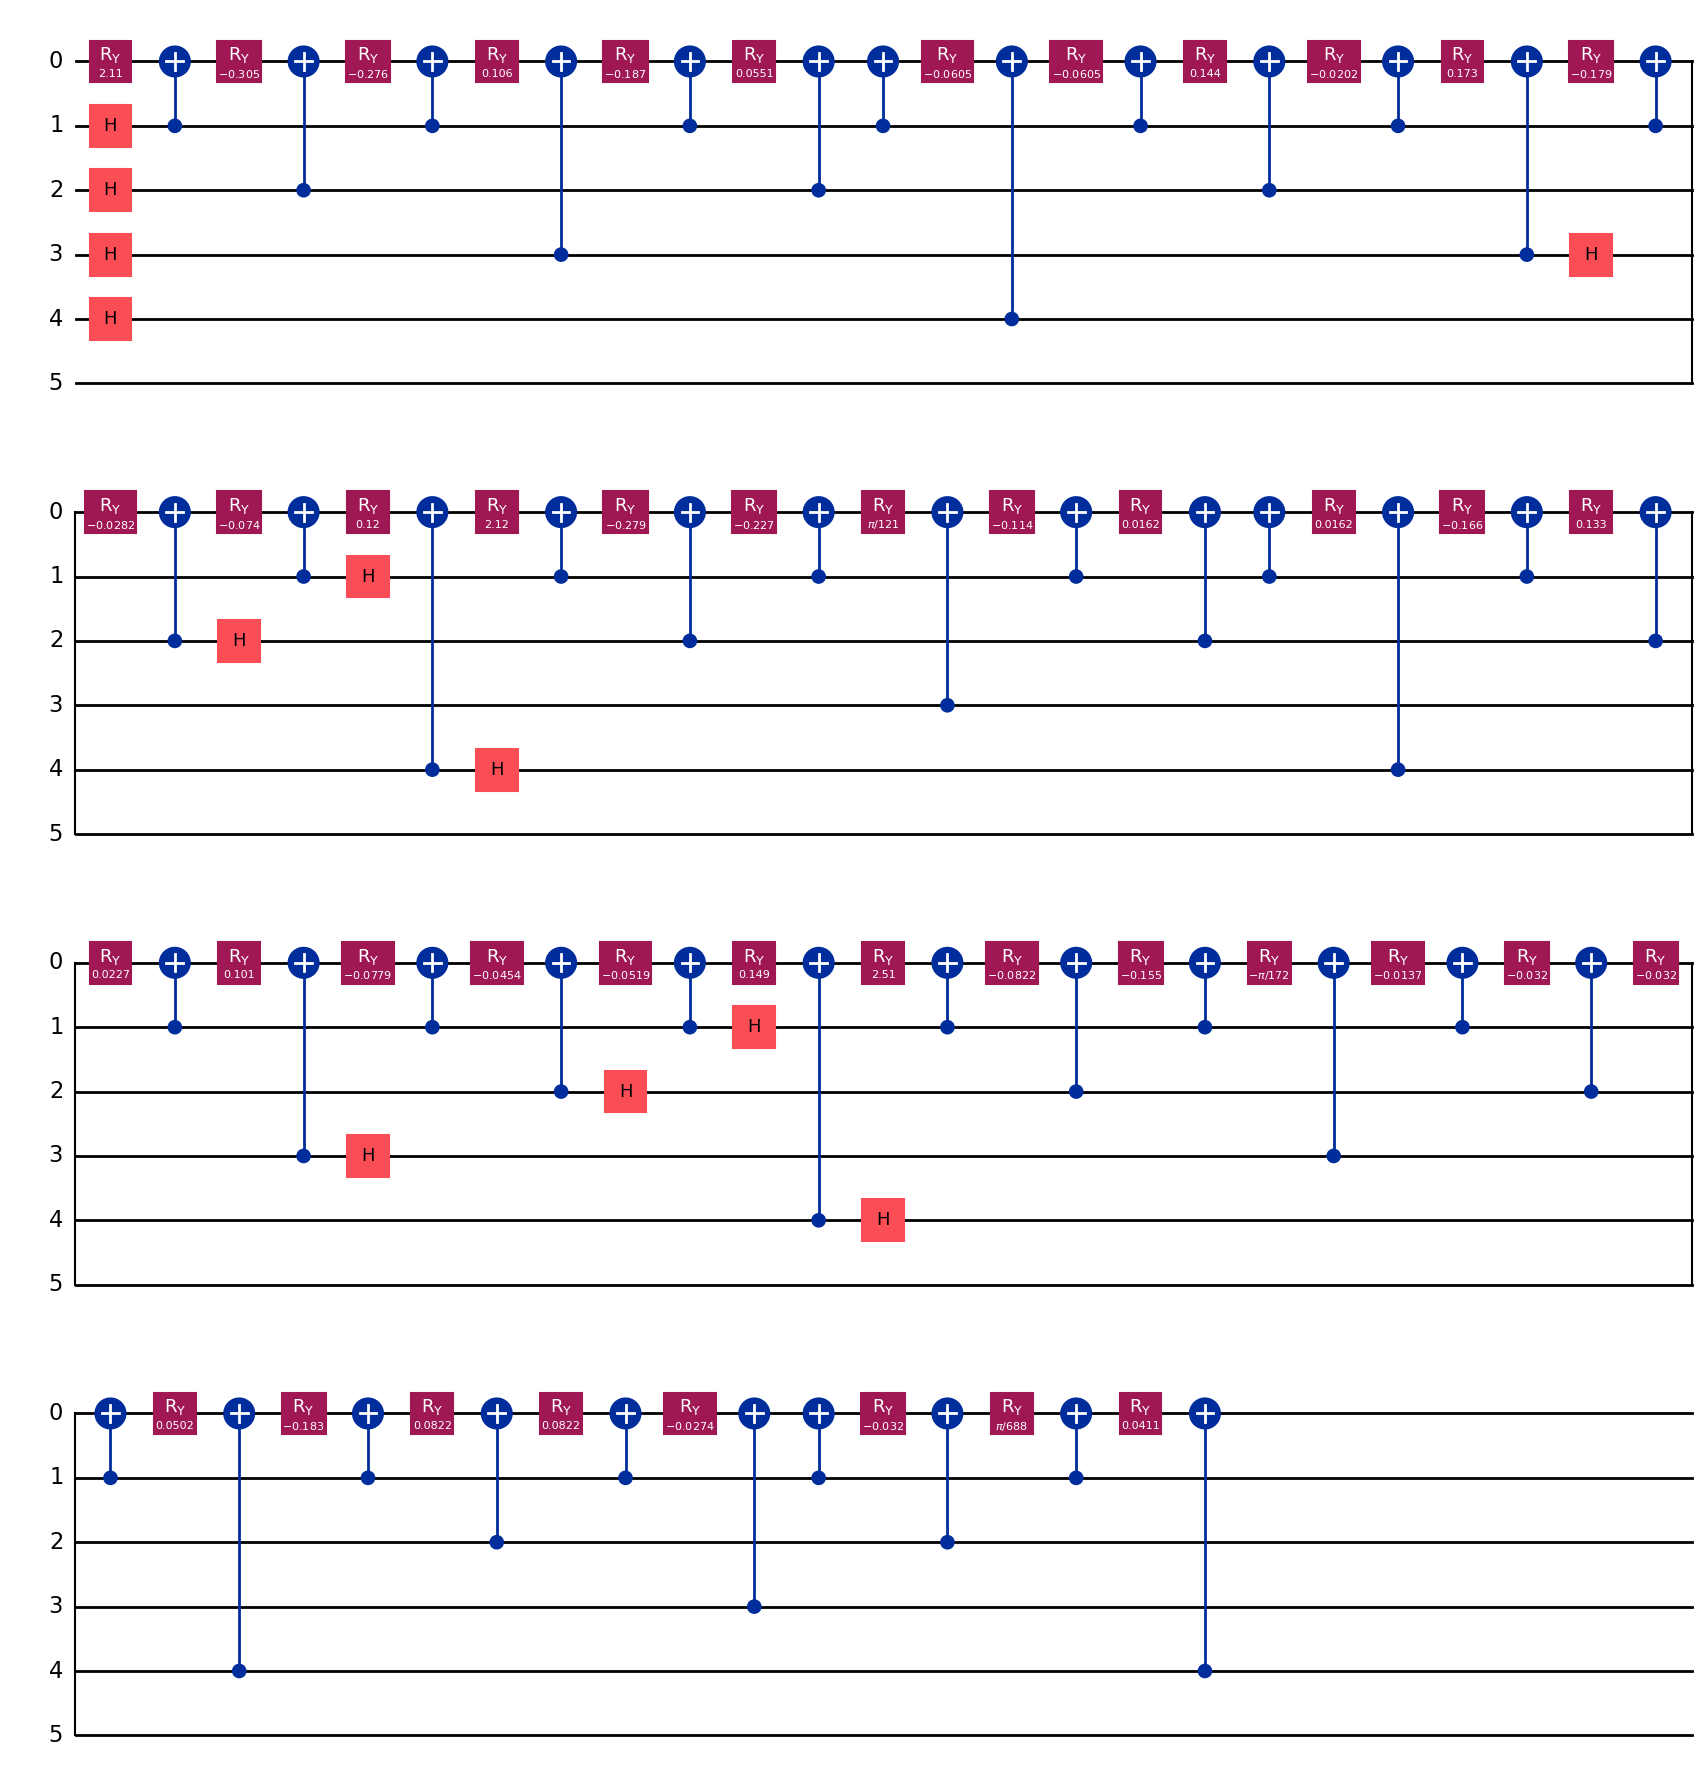

In [21]:
from PIL import Image
import numpy as np
from qiskit import QuantumCircuit
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer

# Load RGB image and resize
img = Image.open("/content/QuantumArtHack/figures/cat.webp").resize((4, 4)).convert("RGB")
r, g, b = img.split()

# Convert each channel to angles in [0, π]
r_angles = (np.array(r) / 255.0 * np.pi).flatten()
g_angles = (np.array(g) / 255.0 * np.pi).flatten()
b_angles = (np.array(b) / 255.0 * np.pi).flatten()

# Create QPIXL modules for each color
r_mod = QPIXLModule(r_angles, compression=10, name="RedChannel")
g_mod = QPIXLModule(g_angles, compression=10, name="GreenChannel")
b_mod = QPIXLModule(b_angles, compression=10, name="BlueChannel")

# Combine using merge (side-by-side)
composer = QuantumComposer([r_mod, g_mod, b_mod])
rgb_combined = composer.combine(rule="merge")

# Visualize
rgb_combined.draw("mpl")


# Test 5: Audio Signal Encoding with QPIXL

This test demonstrates encoding a real audio file into a quantum circuit using QPIXL


*   An audio file is loaded and converted to mono if necessary. The signal is downsampled and truncated to a power-of-2 length



*   Amplitude values are normalized and scaled to rotation angles.
A QPIXL circuit is generated from these angles using cFRQI


*   The resulting quantum circuit captures features of the input audio.

The resulting process_audio() function provides both the angle array and the encoded quantum circuit, which can be directly wrapped in a QPIXLModule or combined with other circuits using QuantumComposer


In [20]:
# AUDIO HELPER (standalone, no patching needed)
import numpy as np
import soundfile as sf
from qiskit import QuantumCircuit
from QPIXL.qiskit.qpixl import cFRQI  # or encode_angles_to_qc

def process_audio(path: str, normalize=True, compression=0):
    data, _ = sf.read(path)
    if len(data.shape) > 1:
        data = data.mean(axis=1)

    samples = data[::200]
    L = 2 ** int(np.floor(np.log2(len(samples))))
    samples = samples[:L]

    if normalize:
        samples = (samples - samples.min()) / (samples.max() - samples.min() + 1e-8)
    angles = samples * np.pi

    circuit = cFRQI(angles, compression)
    return angles, circuit

In [19]:
angles, circuit = process_audio("/content/QuantumArtHack/figures/Ignacio_short.mp3")


[INFO] 16 QPIXL angles from audio signal (trimmed)
▶ Combining using rule: sequential
  ↪ QPIXL_Audio
  ↪ AudioAlgo
✓ Done in 0.00s
[INFO] Using connection map: {0: 5}
▶ Combining using rule: merge
  ↪ QPIXL_Audio
  ↪ AudioAlgo
✓ Done in 0.00s
[RESULT] Qubits: 9
[RESULT] Depth: 27
[RESULT] Gate counts: OrderedDict([('cx', 16), ('ry', 12), ('h', 5)])


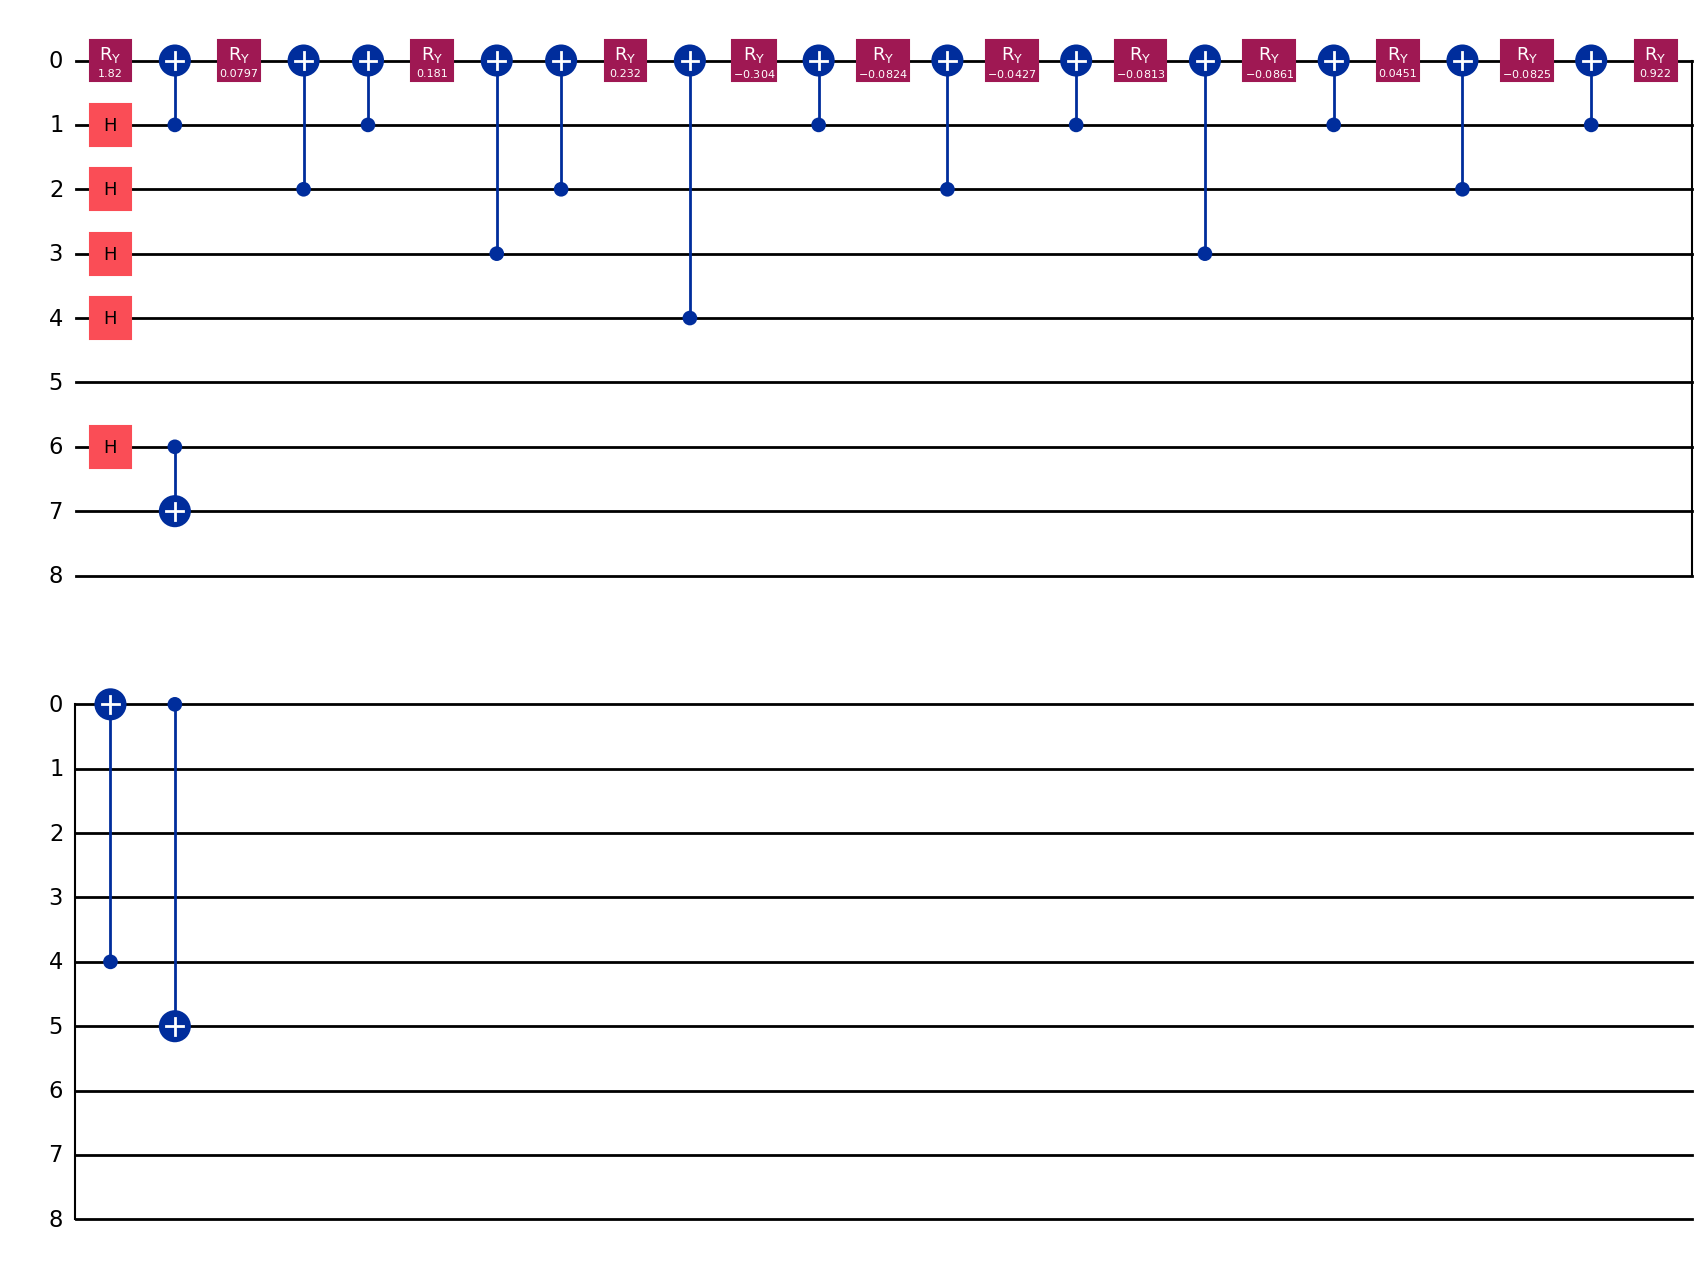

In [18]:
# === TEST: Audio as QPIXL Data + Algorithm Circuit (Merge) ===

from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
from IPython.display import display
import numpy as np
import soundfile as sf

def process_audio(path, compression=25):
    """Preprocess audio to return QPIXL angles + algorithm circuit."""
    audio_data, _ = sf.read(path)
    if len(audio_data.shape) > 1:
        audio_data = audio_data.mean(axis=1)
    audio_data = audio_data[:16]  # Limit for scroll-safe example

    # Normalize and convert to angles
    audio_data = (audio_data - audio_data.min()) / (audio_data.max() - audio_data.min() + 1e-8)
    angles = audio_data * np.pi

    # Simple audio algorithm (3-qubit example)
    from qiskit import QuantumCircuit
    algo = QuantumCircuit(3)
    algo.h(0)
    algo.cx(0, 1)

    return angles, algo

# Step 1: Load and process audio
angles, audio_algo = process_audio("/content/QuantumArtHack/figures/Ignacio_short.mp3", compression=25)
print(f"[INFO] {len(angles)} QPIXL angles from audio signal (trimmed)")

# Step 2: Wrap QPIXL + audio algorithm as modules
qpixl_audio = QPIXLModule(angles, compression=25, name="QPIXL_Audio")
audio_mod = QiskitCircuitModule(audio_algo, name="AudioAlgo")

# Step 3: Safely preview qubit layout
composer_temp = QuantumComposer([qpixl_audio, audio_mod])
combined_temp = composer_temp.combine(rule="sequential")
valid_indices = list(range(combined_temp.num_qubits))

DEBUG = False
if DEBUG:
    print(f"[DEBUG] Qubits: {combined_temp.num_qubits}")
    for idx in valid_indices:
        print(f"  Qubit {idx}")

# Step 4: Safe entanglement map (QPIXL q0 ↔ Algo q5)
requested_map = {
    0: 5
}
connection_map = {
    k: v for k, v in requested_map.items()
    if k in valid_indices and v in valid_indices
}
print(f"[INFO] Using connection map: {connection_map}")

# Step 5: Final composition
composer = QuantumComposer([qpixl_audio, audio_mod])
combined = composer.combine(rule="merge", connection_map=connection_map, entangle_type="cx")

# Step 6: Visualize and summarize
print(f"[RESULT] Qubits: {combined.num_qubits}")
print(f"[RESULT] Depth: {combined.depth()}")
print(f"[RESULT] Gate counts: {combined.count_ops()}")
display(combined.draw("mpl"))


# Test 6: Gate Injection into QPIXL Circuit
This test verifies support for custom gate injection during QPIXL encoding


*   A small grayscale image (8 pixels) is converted into angle data


*   The QPIXLModule is configured with injected_ops, which include:
A RY(π/4) rotation on the first qubit and
a CZ gate between the first and second qubits


*  These operations are injected after the QPIXL encoding but within the same module


This test demonstrates how the QPIXLModule can be extended to include additional computation, manipulation, or entanglement — all while staying modular and composable.




▶ Combining using rule: sequential
  ↪ QPIXL_with_Gates
✓ Done in 0.00s


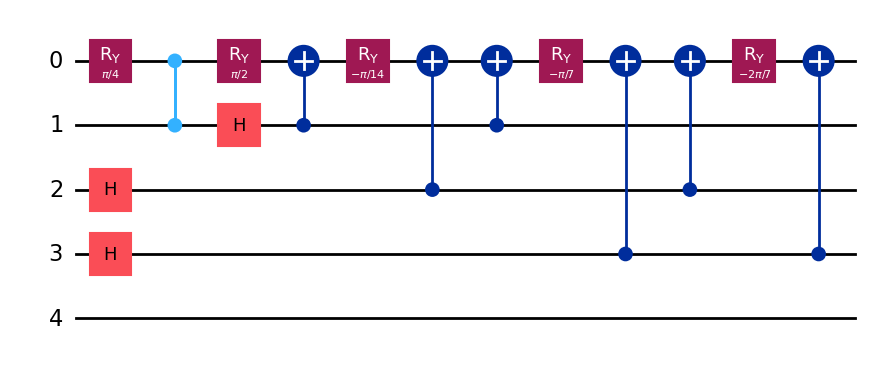

In [17]:
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QuantumComposer
import numpy as np

# Image data
angles = np.linspace(0, np.pi / 2, 8)

# Create QPIXL module
qpixl_mod = QPIXLModule(angles, compression=0, name="QPIXL_with_Gates")

# Inject gates using supported method
qpixl_mod.add_injection("before", "ry", [0], {"angle": np.pi / 4})
qpixl_mod.add_injection("before", "cz", [0, 1])

# Combine using QuantumComposer
composer = QuantumComposer([qpixl_mod])
circuit = composer.combine(rule="sequential")

# Draw
circuit.draw("mpl")



# TEST 6.1:Custom Injection test

This test demonstrates the add_custom_injection() capability of QPIXLModule, allowing advanced logic to be injected during circuit generation.
We define a custom function that applies a gate based on the index and angle of each pixel, and the module calls it during encoding

The module supports all three injection stages:

Before encoding → e.g., initialize extra qubits

During encoding → e.g., apply gates conditionally per pixel angle

After encoding → e.g., apply final entangling or measurement logic

[QPIXL] qubits=6, depth=10, compression=0


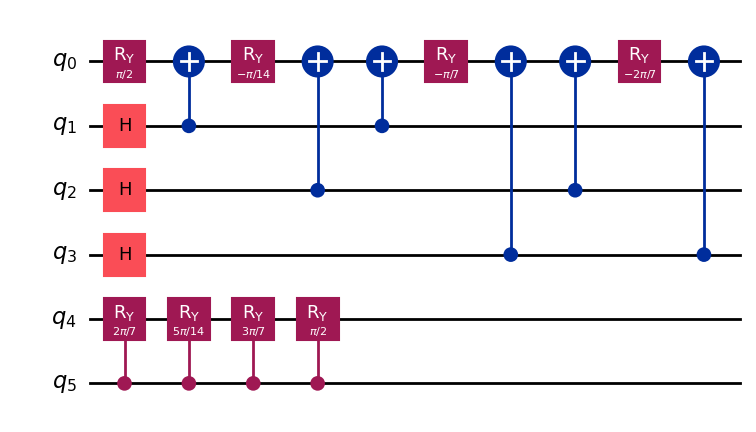

In [16]:
from QPIXL.qiskit.qpixl_module import QPIXLModule, InjectionPoint
from qiskit import QuantumCircuit
import numpy as np

# Sample image array
angles = np.linspace(0, np.pi, 8)

# Define a custom gate injection function
def my_custom_gate(circuit, idx, angle):
    if angle > np.pi / 2:
        q_enc = circuit.qubits[-2]     # encoding qubit
        q_algo = circuit.qubits[-1]    # algorithm qubit
        circuit.cry(angle / 2, q_algo, q_enc)

# Create QPIXLModule with algorithm qubit and custom injection
mod = QPIXLModule(angles, compression=0, algorithm_qubits=1)
mod.add_custom_injection(my_custom_gate, when="during")

# Generate circuit
circuit = mod.get_circuit(verbose=True)
circuit.draw("mpl")


# Test 7: Combined Image, Audio, and Algorithm with Entanglement

This test demonstrates the full capabilities of the QuantumComposer by integrating three distinct components:

A QPIXL circuit from a grayscale image , a QPIXL circuit from an audio file , a standard 3 qubit quantum algorithm

All three modules are merged using the merge rule. Controlled-X entanglement gates are added between
 a qubit from the image circuit and a qubit from the audio circuit another qubit  from the audio circuit and one from the algorithm


== Test 7: Combined Image, Audio, Algorithm + Entanglement ==
▶ Combining using rule: sequential
  ↪ ImageQPIXL
  ↪ AudioQPIXL
  ↪ SimpleAlgo
✓ Done in 0.00s
[INFO] Using safe entanglement map: {0: 5, 7: 8}
▶ Combining using rule: merge
  ↪ ImageQPIXL
  ↪ AudioQPIXL
  ↪ SimpleAlgo
✓ Done in 0.00s
[RESULT] Total qubits: 9
[RESULT] Circuit depth: 56
[RESULT] Gate counts: OrderedDict([('cx', 33), ('ry', 25), ('h', 9)])


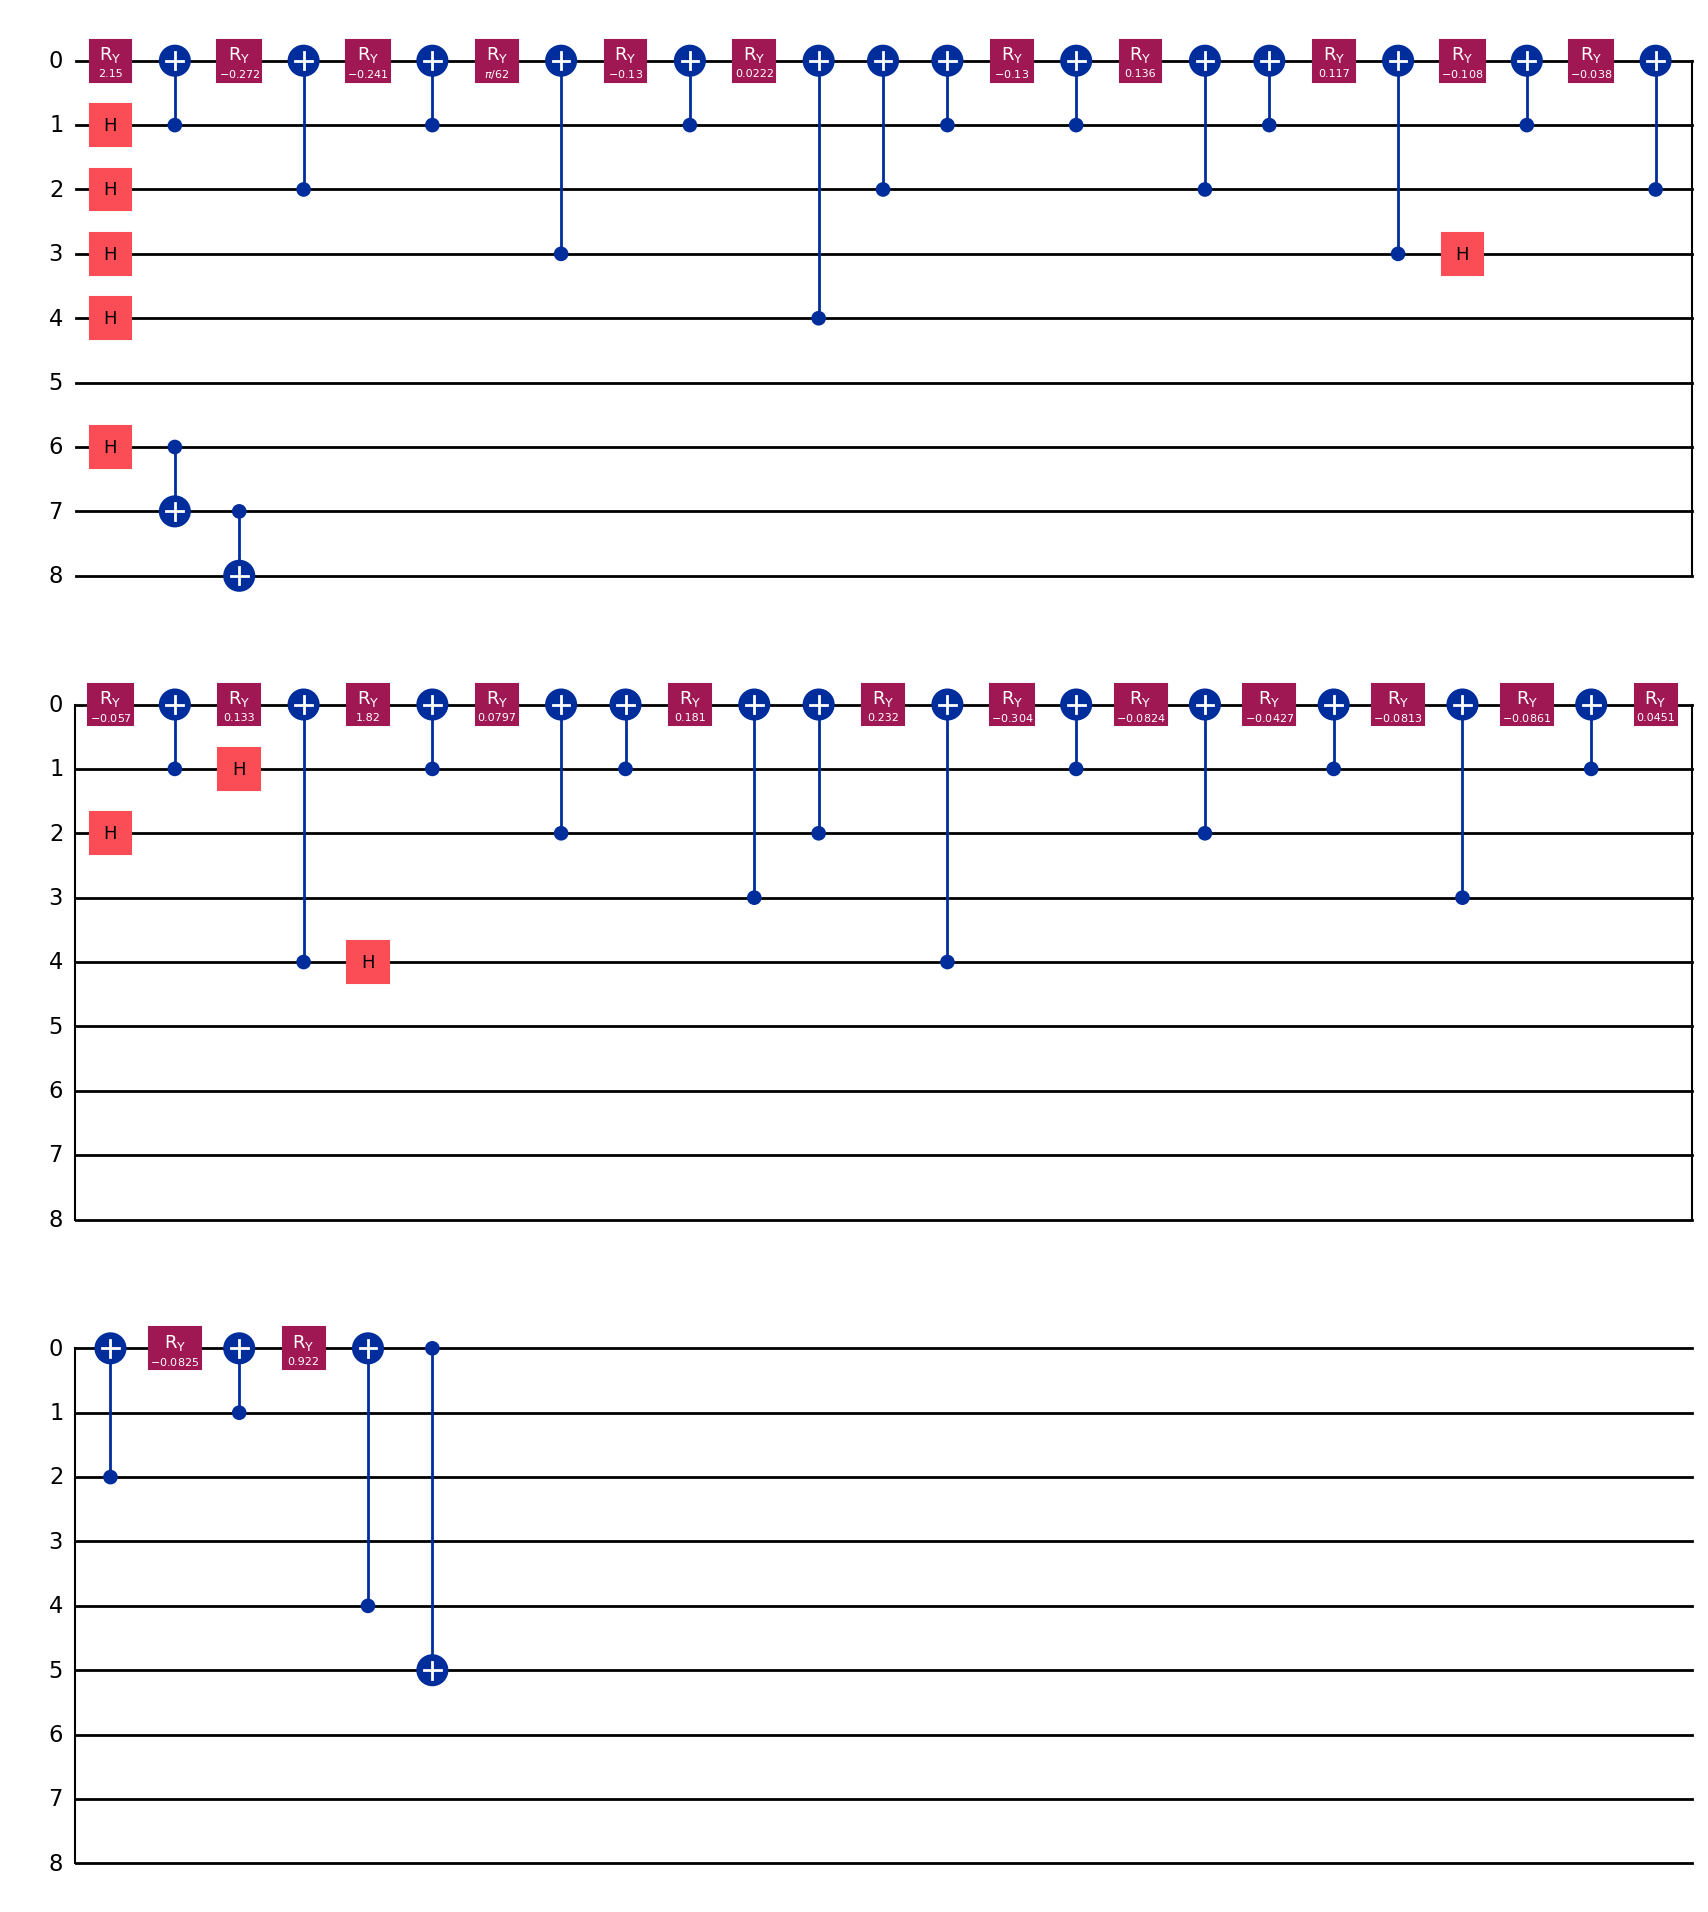

In [15]:
# === Test 7: Combined Image, Audio, Algorithm + Entanglement ===

from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
from qiskit import QuantumCircuit
import numpy as np
from PIL import Image
import soundfile as sf
from IPython.display import display

print("\n== Test 7: Combined Image, Audio, Algorithm + Entanglement ==")

# -- 1. Image Module (4x4 grayscale → 16 pixels → 5 qubits)
img = Image.open("/content/QuantumArtHack/figures/cat.webp").convert("L").resize((4, 4))
image_angles = (np.array(img) / 255.0 * np.pi).flatten()
image_mod = QPIXLModule(image_angles, compression=20, name="ImageQPIXL")

# -- 2. Audio Module (first 16 samples → 5 qubits)
audio_data, _ = sf.read("/content/QuantumArtHack/figures/Ignacio_short.mp3")
if len(audio_data.shape) > 1:
    audio_data = audio_data.mean(axis=1)
audio_data = audio_data[:16]
audio_data = (audio_data - audio_data.min()) / (audio_data.max() - audio_data.min() + 1e-8)
audio_angles = audio_data * np.pi
audio_mod = QPIXLModule(audio_angles, compression=25, name="AudioQPIXL")

# -- 3. Simple Algorithm Module (3 qubits)
algo = QuantumCircuit(3)
algo.h(0)
algo.cx(0, 1)
algo_mod = QiskitCircuitModule(algo, name="SimpleAlgo")

# -- 4. Dry-run composition to get actual qubit layout
composer_temp = QuantumComposer([image_mod, audio_mod, algo_mod])
combined_temp = composer_temp.combine(rule="sequential")
total_qubits = combined_temp.num_qubits
valid_indices = list(range(total_qubits))

# -- Optional: Debug output (turn on for layout inspection)
DEBUG = False
if DEBUG:
    print(f"[DEBUG] Total Qubits: {total_qubits}")
    for idx in valid_indices:
        print(f"  Qubit {idx}")

# -- 5. Safe entanglement map (filtered to stay within bounds)
requested_map = {
    0: 5,   # image q0 ↔ audio q0
    7: 8    # audio q2 ↔ algo q0
}
connection_map = {
    k: v for k, v in requested_map.items()
    if k in valid_indices and v in valid_indices
}
print(f"[INFO] Using safe entanglement map: {connection_map}")

# -- 6. Final composition with merge and entanglement
composer = QuantumComposer([image_mod, audio_mod, algo_mod])
combined = composer.combine(
    rule="merge",
    connection_map=connection_map,
    entangle_type="cx"
)

# -- 7. Show results
print(f"[RESULT] Total qubits: {combined.num_qubits}")
print(f"[RESULT] Circuit depth: {combined.depth()}")
print(f"[RESULT] Gate counts: {combined.count_ops()}")
display(combined.draw("mpl"))



# Test 8: Hardware-Aware Transpilation with a Custom Coupling Map

This test shows how the QuantumComposer supports hardware-aware transpilation using Qiskit’s transpiler.

*   A QPIXL circuit (8 qubits) is combined with a simple 3-qubit algorithm using the sequential rule

*   A linear 8-qubit coupling map is defined to simulate a hardware layout
*   The composed circuit is passed to Qiskit's transpiler with custom constraints:
Basis gates: ["cx", "u3"]
, Optimization level: 1
, Coupling map: linear 8-qubit chain


The output circuit shows any rewrites, swap insertions, or gate adjustments based on connectivity

This confirms that circuits created through QuantumComposer are compatible with hardware-aware execution paths.



▶ Combining using rule: hardware_aware_sequential
  ↪ QPIXLImg
  ↪ MiniAlgo
✓ Done in 0.07s
Transpiled depth: 19
Transpiled qubits: 9


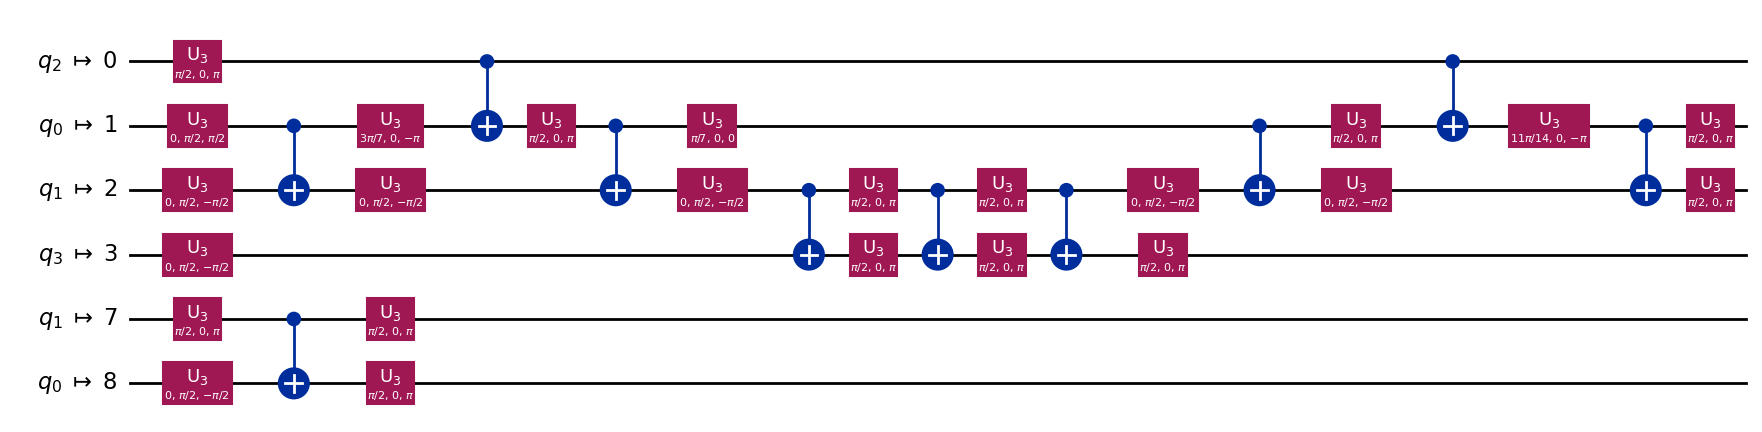

In [14]:
from qiskit.transpiler import CouplingMap
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
import numpy as np
from qiskit import QuantumCircuit

# Prepare QPIXL and algorithm circuits
angles = np.linspace(0, np.pi / 2, 8)
qpixl = QPIXLModule(angles, compression=0, name="QPIXLImg")
algo = QuantumCircuit(3); algo.h(0); algo.cx(0, 1)
algo_mod = QiskitCircuitModule(algo, name="MiniAlgo")

# Combine them with the composer
composer = QuantumComposer([qpixl, algo_mod])

# Define a larger fake coupling map with 8 qubits (linear topology)
larger_map = CouplingMap([[i, i + 1] for i in range(8)])

# Combine with transpilation for hardware-awareness
combined_hw = composer.combine(
    rule="hardware_aware_sequential",
    coupling_map=larger_map,
    basis_gates=["cx", "u3"],
    optimization_level=1
)

# Visualize and show circuit metadata
print("Transpiled depth:", combined_hw.depth())
print("Transpiled qubits:", combined_hw.num_qubits)
combined_hw.draw("mpl")

# Test: Algorithm–QPIXL Interaction During Encoding
This test shows direct entanglement between an algorithm qubit and the QPIXL encoding qubit. We inject a CRY gate during the encoding loop, so the algorithm qubit actually influences the QPIXL-encoded data.

▶ Combining using rule: sequential
  ↪ AlgoInit
  ↪ InteractiveQPIXL
✓ Done in 0.00s


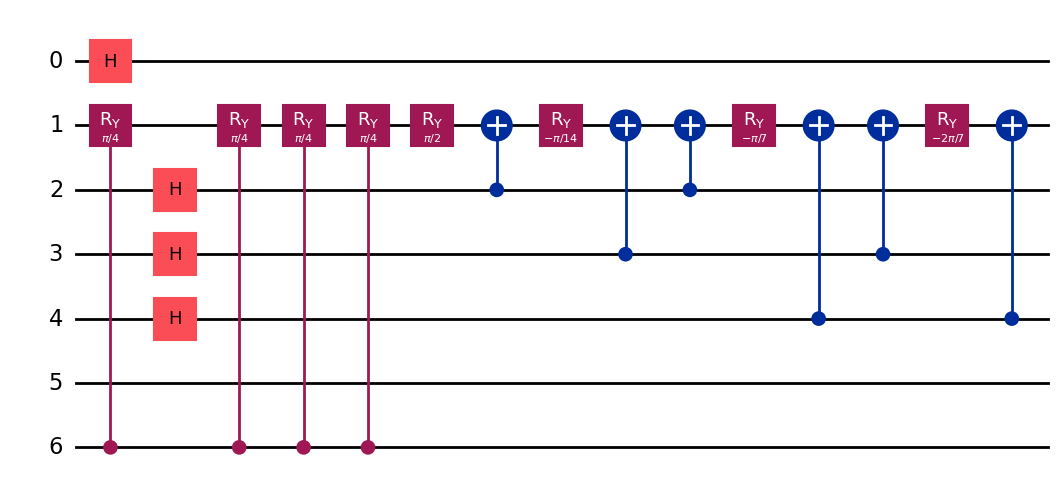

In [13]:
#Algorithm qubit controls encoding qubit via CRY
import numpy as np, math
from qiskit import QuantumCircuit
from QPIXL.qiskit.qpixl_module import QPIXLModule, InjectionPoint
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer

data = np.linspace(0, np.pi/2, 8)

mod = QPIXLModule(data, compression=0, name="InteractiveQPIXL", algorithm_qubits=1)
mod.add_injection(
    when=InjectionPoint.DURING_ENCODING,
    gate_type="cry",
    qubits=[-1, 0],                 # algo_qubit → encoding_qubit
    params={"angle": math.pi/4},
    condition=lambda i, angle: i % 2 == 0
)

algo = QuantumCircuit(1, name="AlgoInit")
algo.h(0)
algo_mod = QiskitCircuitModule(algo, "AlgoInit")

composer = QuantumComposer([algo_mod, mod])
combined = composer.combine(rule="sequential")
combined.draw("mpl")


# Test: Cross-Sliced Circuit Composition with Entanglement

This test demonstrates our final slice rule, where:

Both the QPIXL data circuit and the algorithm circuit are sliced into segments.

These slices are interleaved together, forming an intertwined execution pipeline.

At each insertion point, we connect the modules using a configurable entanglement rule (e.g., cx, cz, swap).

In this example, QPIXL qubit 2 is connected to algorithm qubit 0 using a controlled-X (cx) gate.

▶ Combining using rule: slice
✓ Done in 0.00s


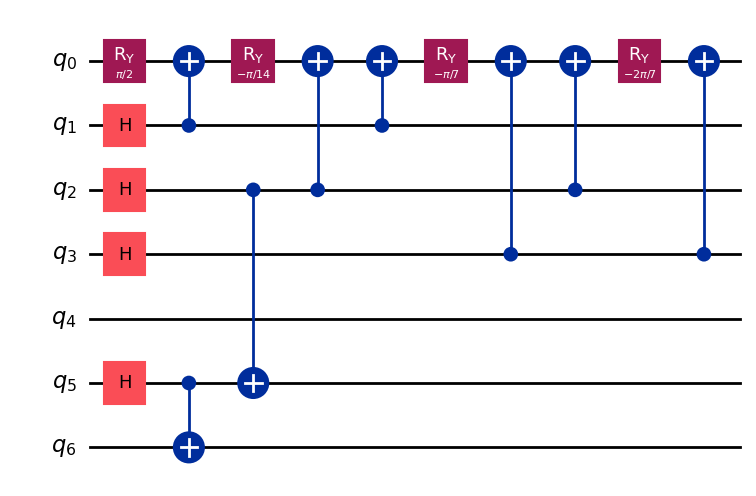

In [12]:
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
from qiskit import QuantumCircuit
import numpy as np

# 1) Create modules
data_mod = QPIXLModule(np.linspace(0, np.pi/2, 8), name="QPIXLDATA")
algo    = QuantumCircuit(2)
algo.h(0); algo.cx(0,1)
algo_mod = QiskitCircuitModule(algo, name="ALGO")

# 2) Compose with slicing
composer = QuantumComposer([data_mod, algo_mod])
combined = composer.combine(
    rule="slice",
    slice_size=4,
    connection_rule="cx",
    connection_map=[(2, 0)]  # Connects qubit 2 of data to qubit 0 of algo
)

# 3) Draw
combined.draw("mpl")


# Test: Slicing with Multiple Entanglement Connections

This test showcases

The QPIXL image module and algorithm circuit are both sliced into smaller segments (every 2 gates).

Slices are interleaved, preserving logical order from both modules.

At each step, we apply multiple entangling gates:

cx(0,0) connects qubit 0 from the QPIXL module to qubit 0 of the algorithm slice.

cx(1,1) similarly connects qubit 1 from QPIXL to algo qubit 1.

This proves our support for multi-qubit connectivity between slices, completing the "bidirectional sliced entanglement"

▶ Combining using rule: slice
✓ Done in 0.00s


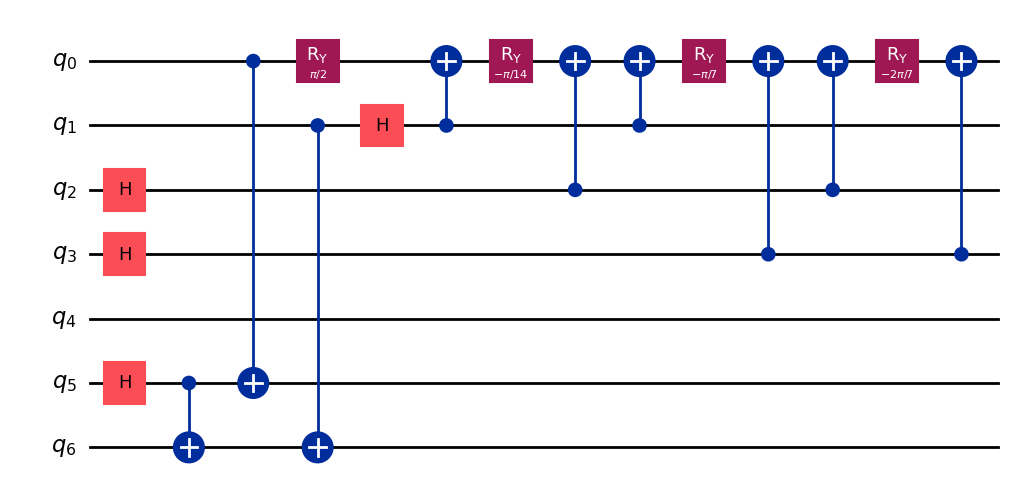

In [11]:
from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
import numpy as np
from qiskit import QuantumCircuit

data = np.linspace(0, np.pi/2, 8)
qpixl = QPIXLModule(data, name="DataMod")
algo = QuantumCircuit(2); algo.h(0); algo.cx(0,1)
algo_mod = QiskitCircuitModule(algo, name="AlgoMod")

comp = QuantumComposer([qpixl, algo_mod])
circ = comp.combine(
  rule="slice",
  slice_size=2,
  connection_rule="cx",
  connection_map=[(0,0), (1,1)]
)
circ.draw("mpl")


# Test: Sliced Algorithm Interleaved into QPIXL with Entanglement

This test demonstrates the advanced integration of an algorithm circuit into the QPIXL encoding pipeline using create_sliced_circuit.

The QPIXL circuit encodes 16-pixel image data with 20% compression.

The algorithm circuit (with 2 qubits) is sliced every 2 gates.

Each slice is inserted during the QPIXL encoding loop.

At each insertion point, a CZ entanglement is applied from QPIXL qubit 2 to algorithm qubit 0, as specified by the connection_map.

This test showcases:

- Smart gate slicing of the algorithm.

- Interleaved placement into a nontrivial QPIXL circuit.

- Controlled entanglement pattern across module boundaries.

[QPIXL] Interleaved 2 slices:
  ↪ At index 0: inserted slice 0
  ↪ At index 8: inserted slice 1


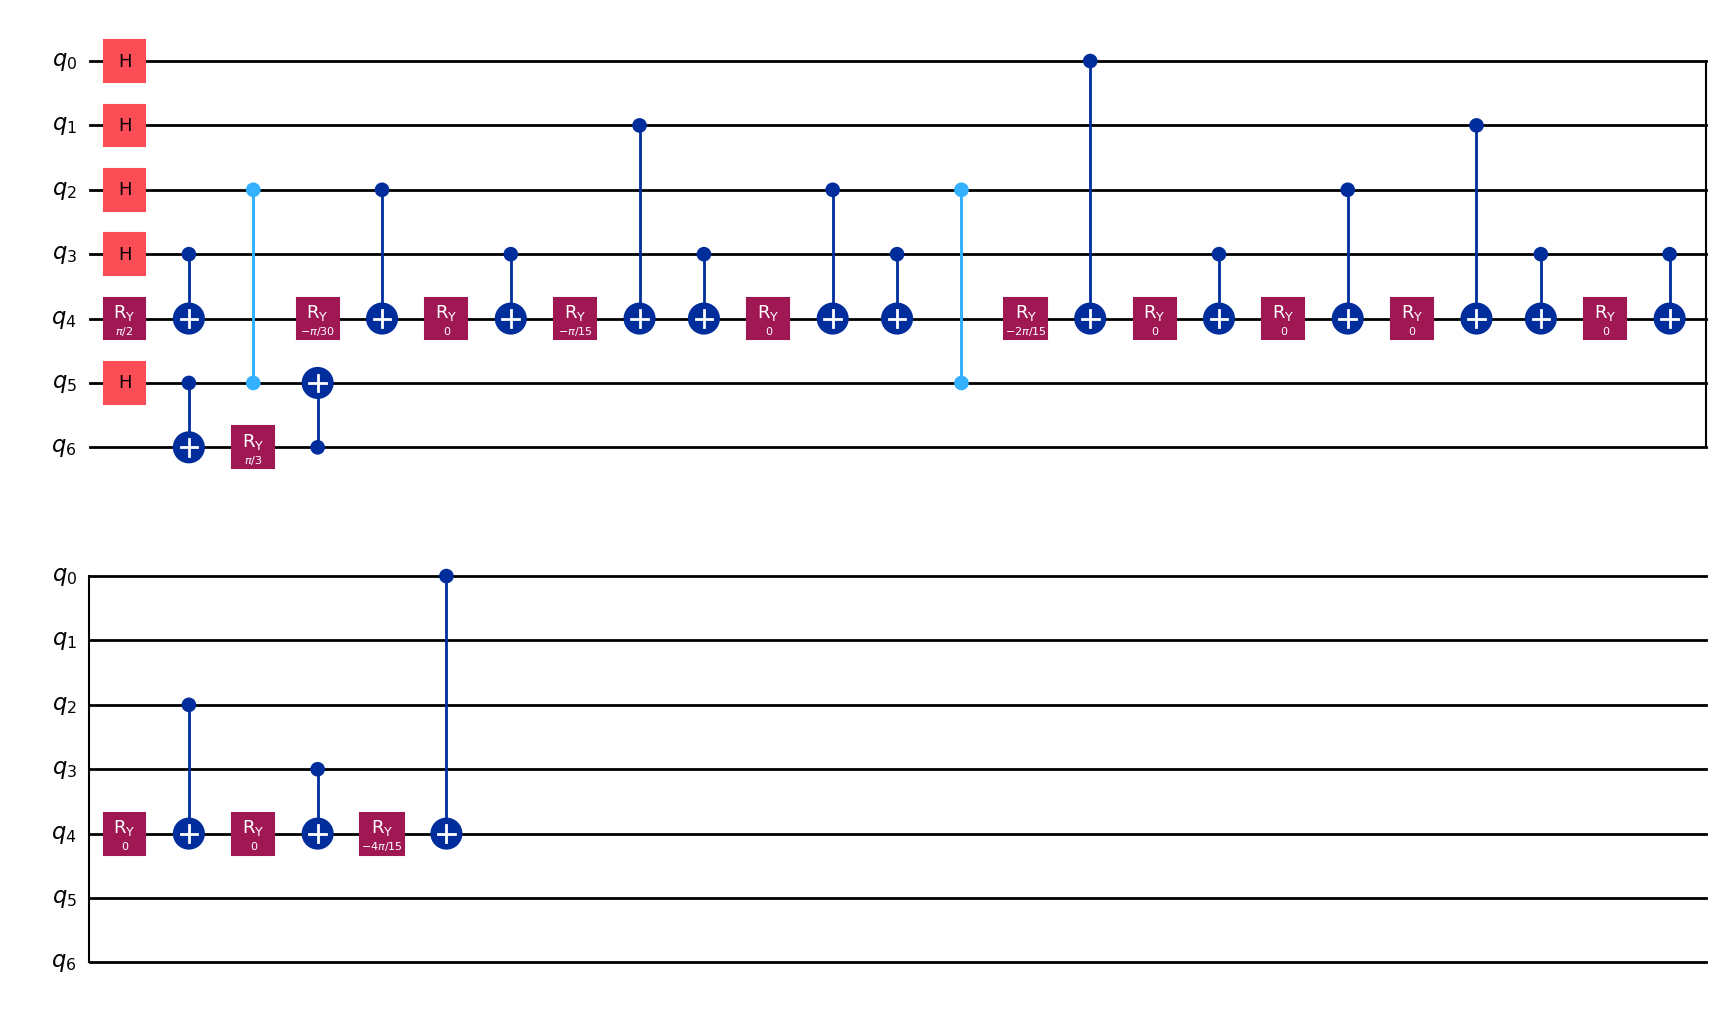

In [10]:
from QPIXL.qiskit.quantum_composer import create_sliced_circuit
from qiskit import QuantumCircuit
import numpy as np

# --- 1. Create image input ---
image = np.linspace(0, np.pi / 2, 16)  # 1D image data
algo = QuantumCircuit(2)
algo.h(0)
algo.cx(0, 1)
algo.ry(np.pi/3, 1)
algo.cx(1, 0)

# --- 2. Define connection pattern ---
conn_map = {2: 0}  # QPIXL data qubit 2 ↔ algo qubit 0

# --- 3. Compose circuit with slicing and connection ---
combined = create_sliced_circuit(
    image_array=image,
    compression=20,
    algorithm_circuit=algo,
    slice_size=2,
    connection_rule="cz",           # Entangling gate between data + algo
    connection_map=conn_map,
    name="QPIXL_Interleaved"
)

# --- 4. Visualize ---
combined.draw("mpl")


# Test: Dual-Sliced Module Composition with CZ Connections

This test demonstrates the full slicing-based integration of two distinct modules — a QPIXL-encoded image circuit and a 2-qubit quantum algorithm.

The QPIXLModule encodes 16 values using a compressed cFRQI encoding.

The Algorithm Module consists of 4 gates: H, CX, RY, CZ — and is sliced every 2 gates.

The QuantumComposer is used to interleave these alternating slices, mimicking layered hybrid circuits.

A CZ entanglement is inserted at every boundary, connecting:

QPIXL data qubit 1
with Algorithm qubit 0

Ihope this setup fulfills the requirements as it :
- Slices both QPIXL and the algorithm circuit.
-Interleaves them alternately.
Adds connection gates between qubits at each boundary.



▶ Combining using rule: slice
✓ Done in 0.01s
[RESULT] Qubits: 12
[RESULT] Gate counts: OrderedDict([('cx', 32), ('ry', 30), ('cz', 18), ('h', 8)])
[RESULT] Registers: ['q']


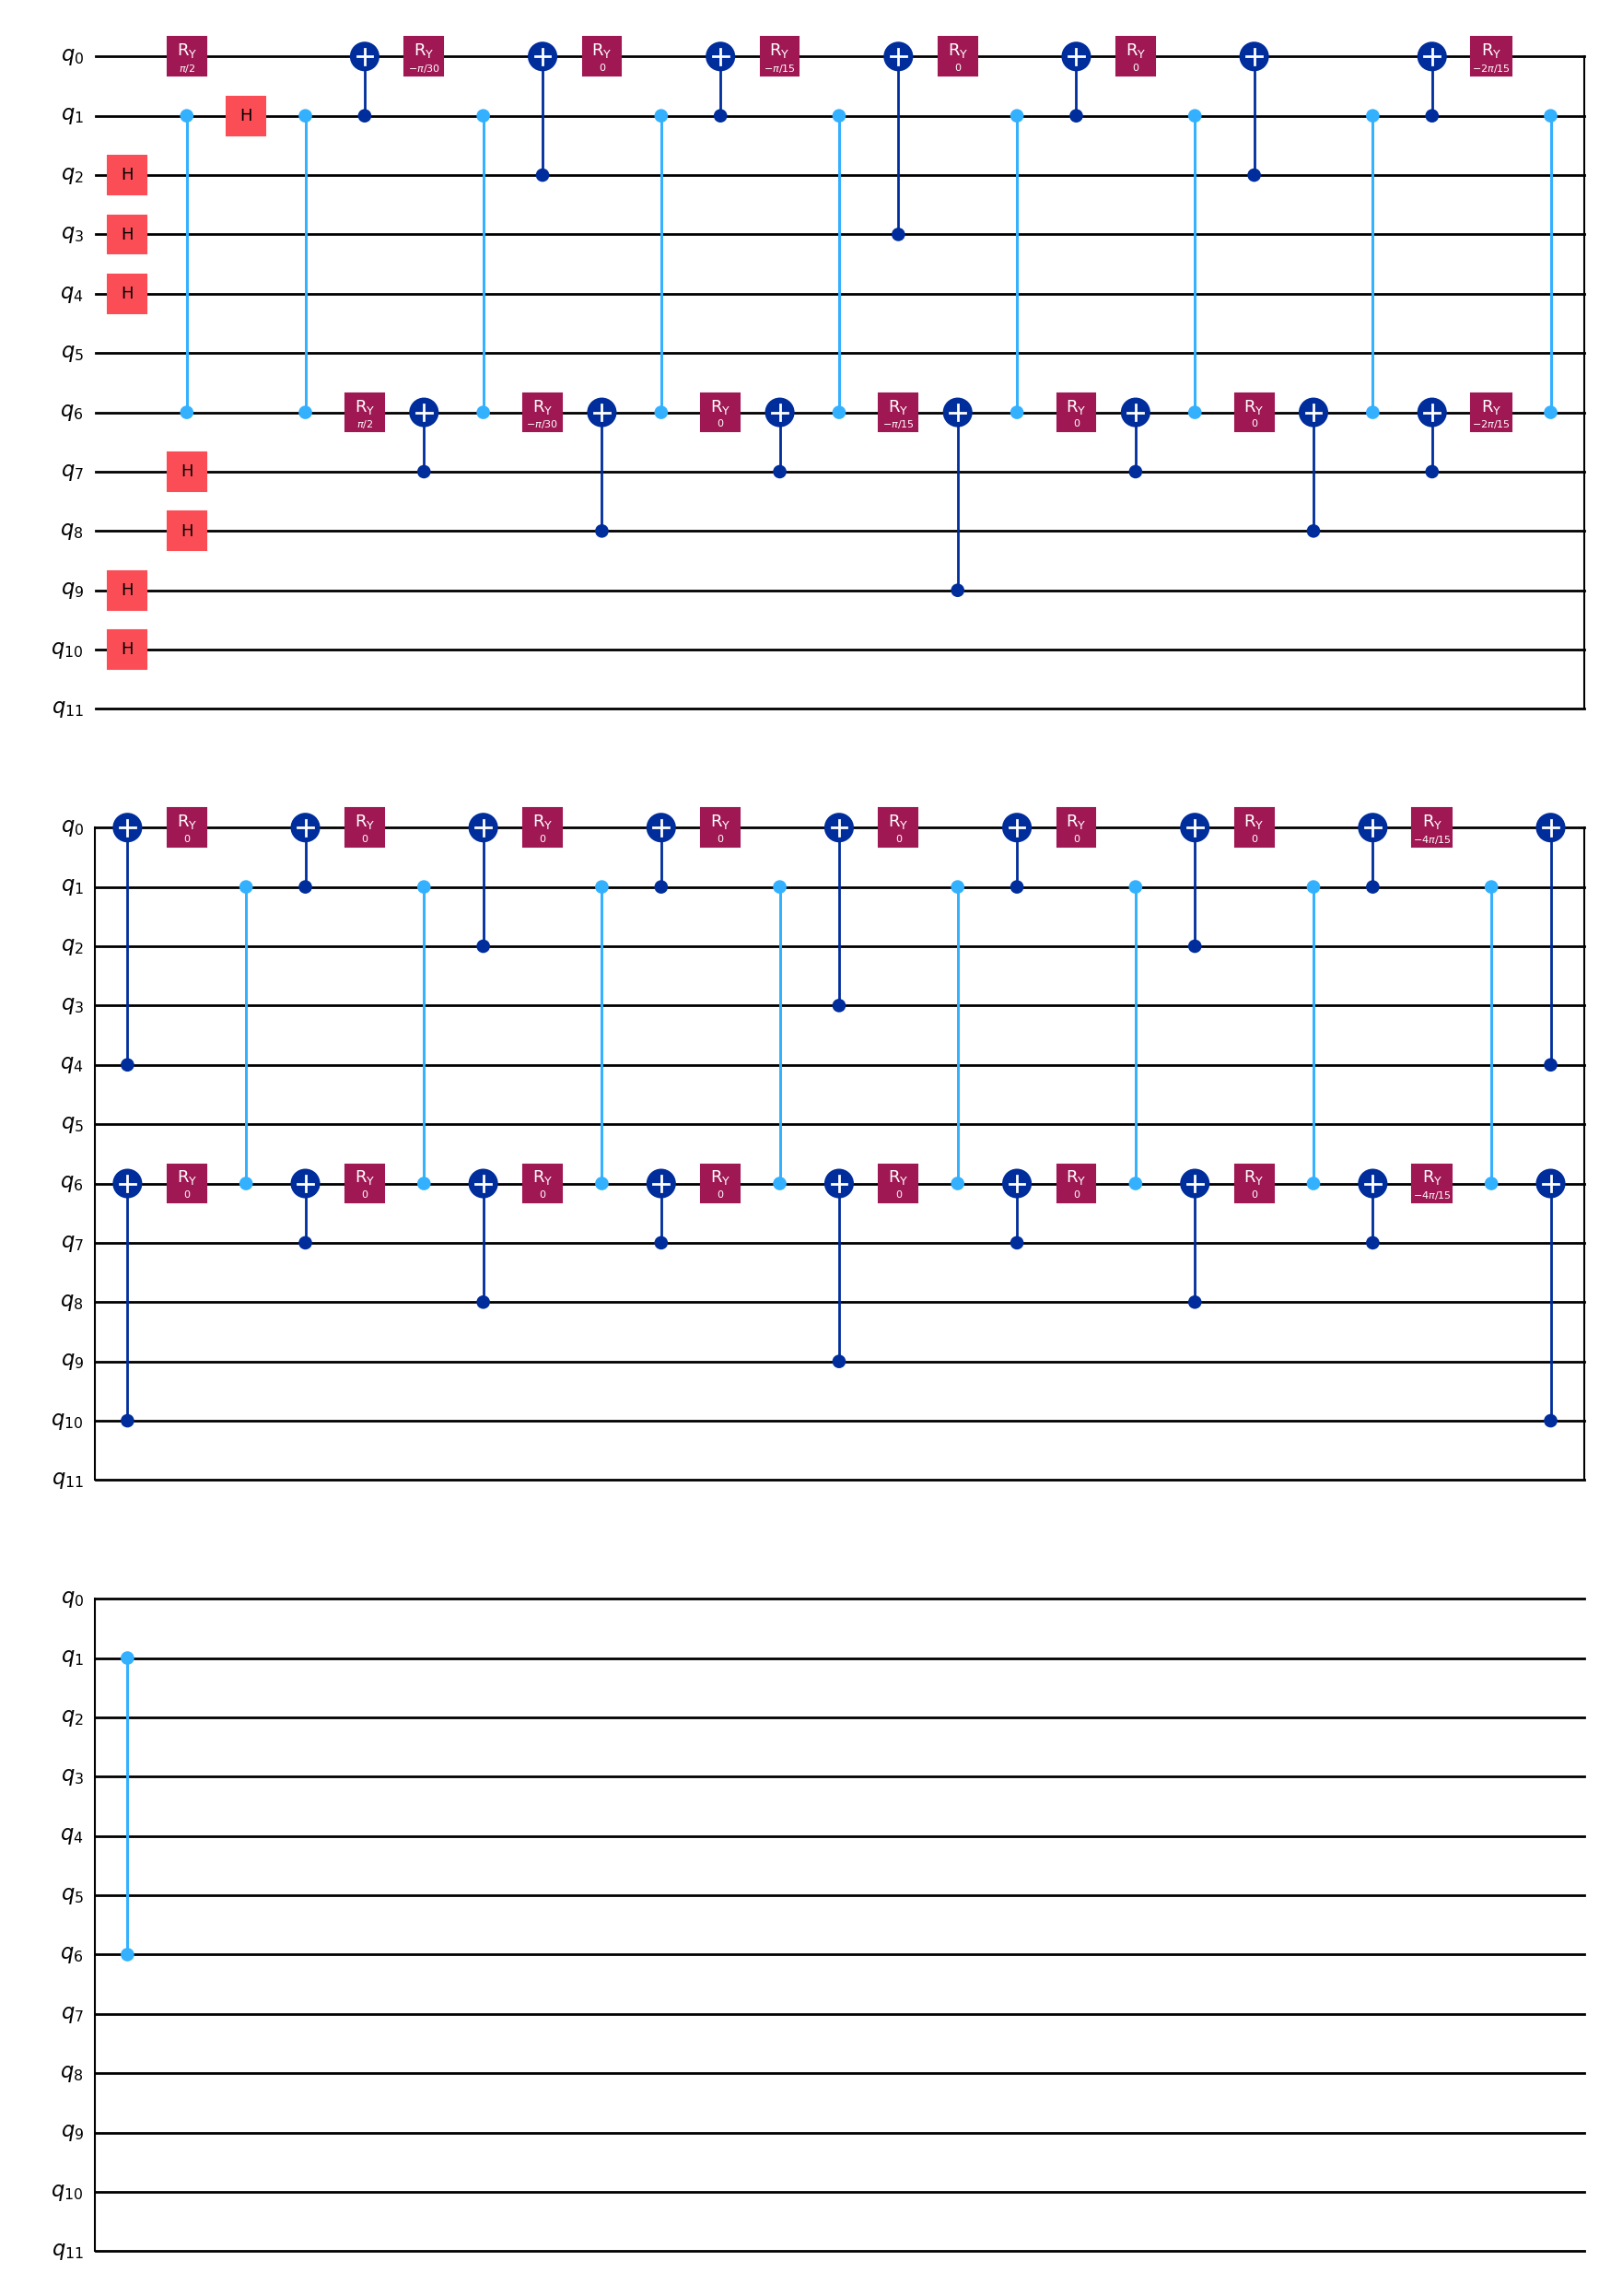

In [8]:
# === TEST: Dual QPIXL Slicing with CZ Entanglement ===

from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
import numpy as np
from IPython.display import display

# Step 1: Generate simple QPIXL data (4×4 grayscale)
image_data = np.linspace(0, np.pi / 2, 16)

# Step 2: Create two QPIXL modules
qpixl_mod_1 = QPIXLModule(image_data, name="QPIXLDATA_1")
qpixl_mod_2 = QPIXLModule(image_data, name="QPIXLDATA_2")
algo_mod = QiskitCircuitModule(qpixl_mod_2.get_circuit(), name="QPIXLDATA_2_ALGO")

# Step 3: Compose with slicing + CZ entanglement between slices
composer = QuantumComposer([qpixl_mod_1, algo_mod])
combined = composer.combine(
    rule="slice",
    slice_size=2,
    connection_rule="cz",
    connection_map=[(1, 0)]  # QPIXL_1 qubit 1 ↔ QPIXL_2 qubit 0
)

# Step 4: Display result and confirm clean register usage
print(f"[RESULT] Qubits: {combined.num_qubits}")
print(f"[RESULT] Gate counts: {combined.count_ops()}")
print(f"[RESULT] Registers: {[reg.name for reg in combined.qregs]}")
display(combined.draw("mpl"))


# Dual QPIXL Slice Composition — Removing Ghost Qubits

This test ensures that slicing two QPIXLModule circuits together using the "slice" rule with entanglement produces a clean circuit:

No ghost qubits

No extra unused registers

No visual imbalance

Proper entanglement between corresponding slices

▶ Combining using rule: slice
✓ Done in 0.01s
[TEST] Qubits: 12
[TEST] Gate Count: OrderedDict([('cz', 36), ('cx', 32), ('ry', 30), ('h', 8)])
[TEST] Registers: ['q']


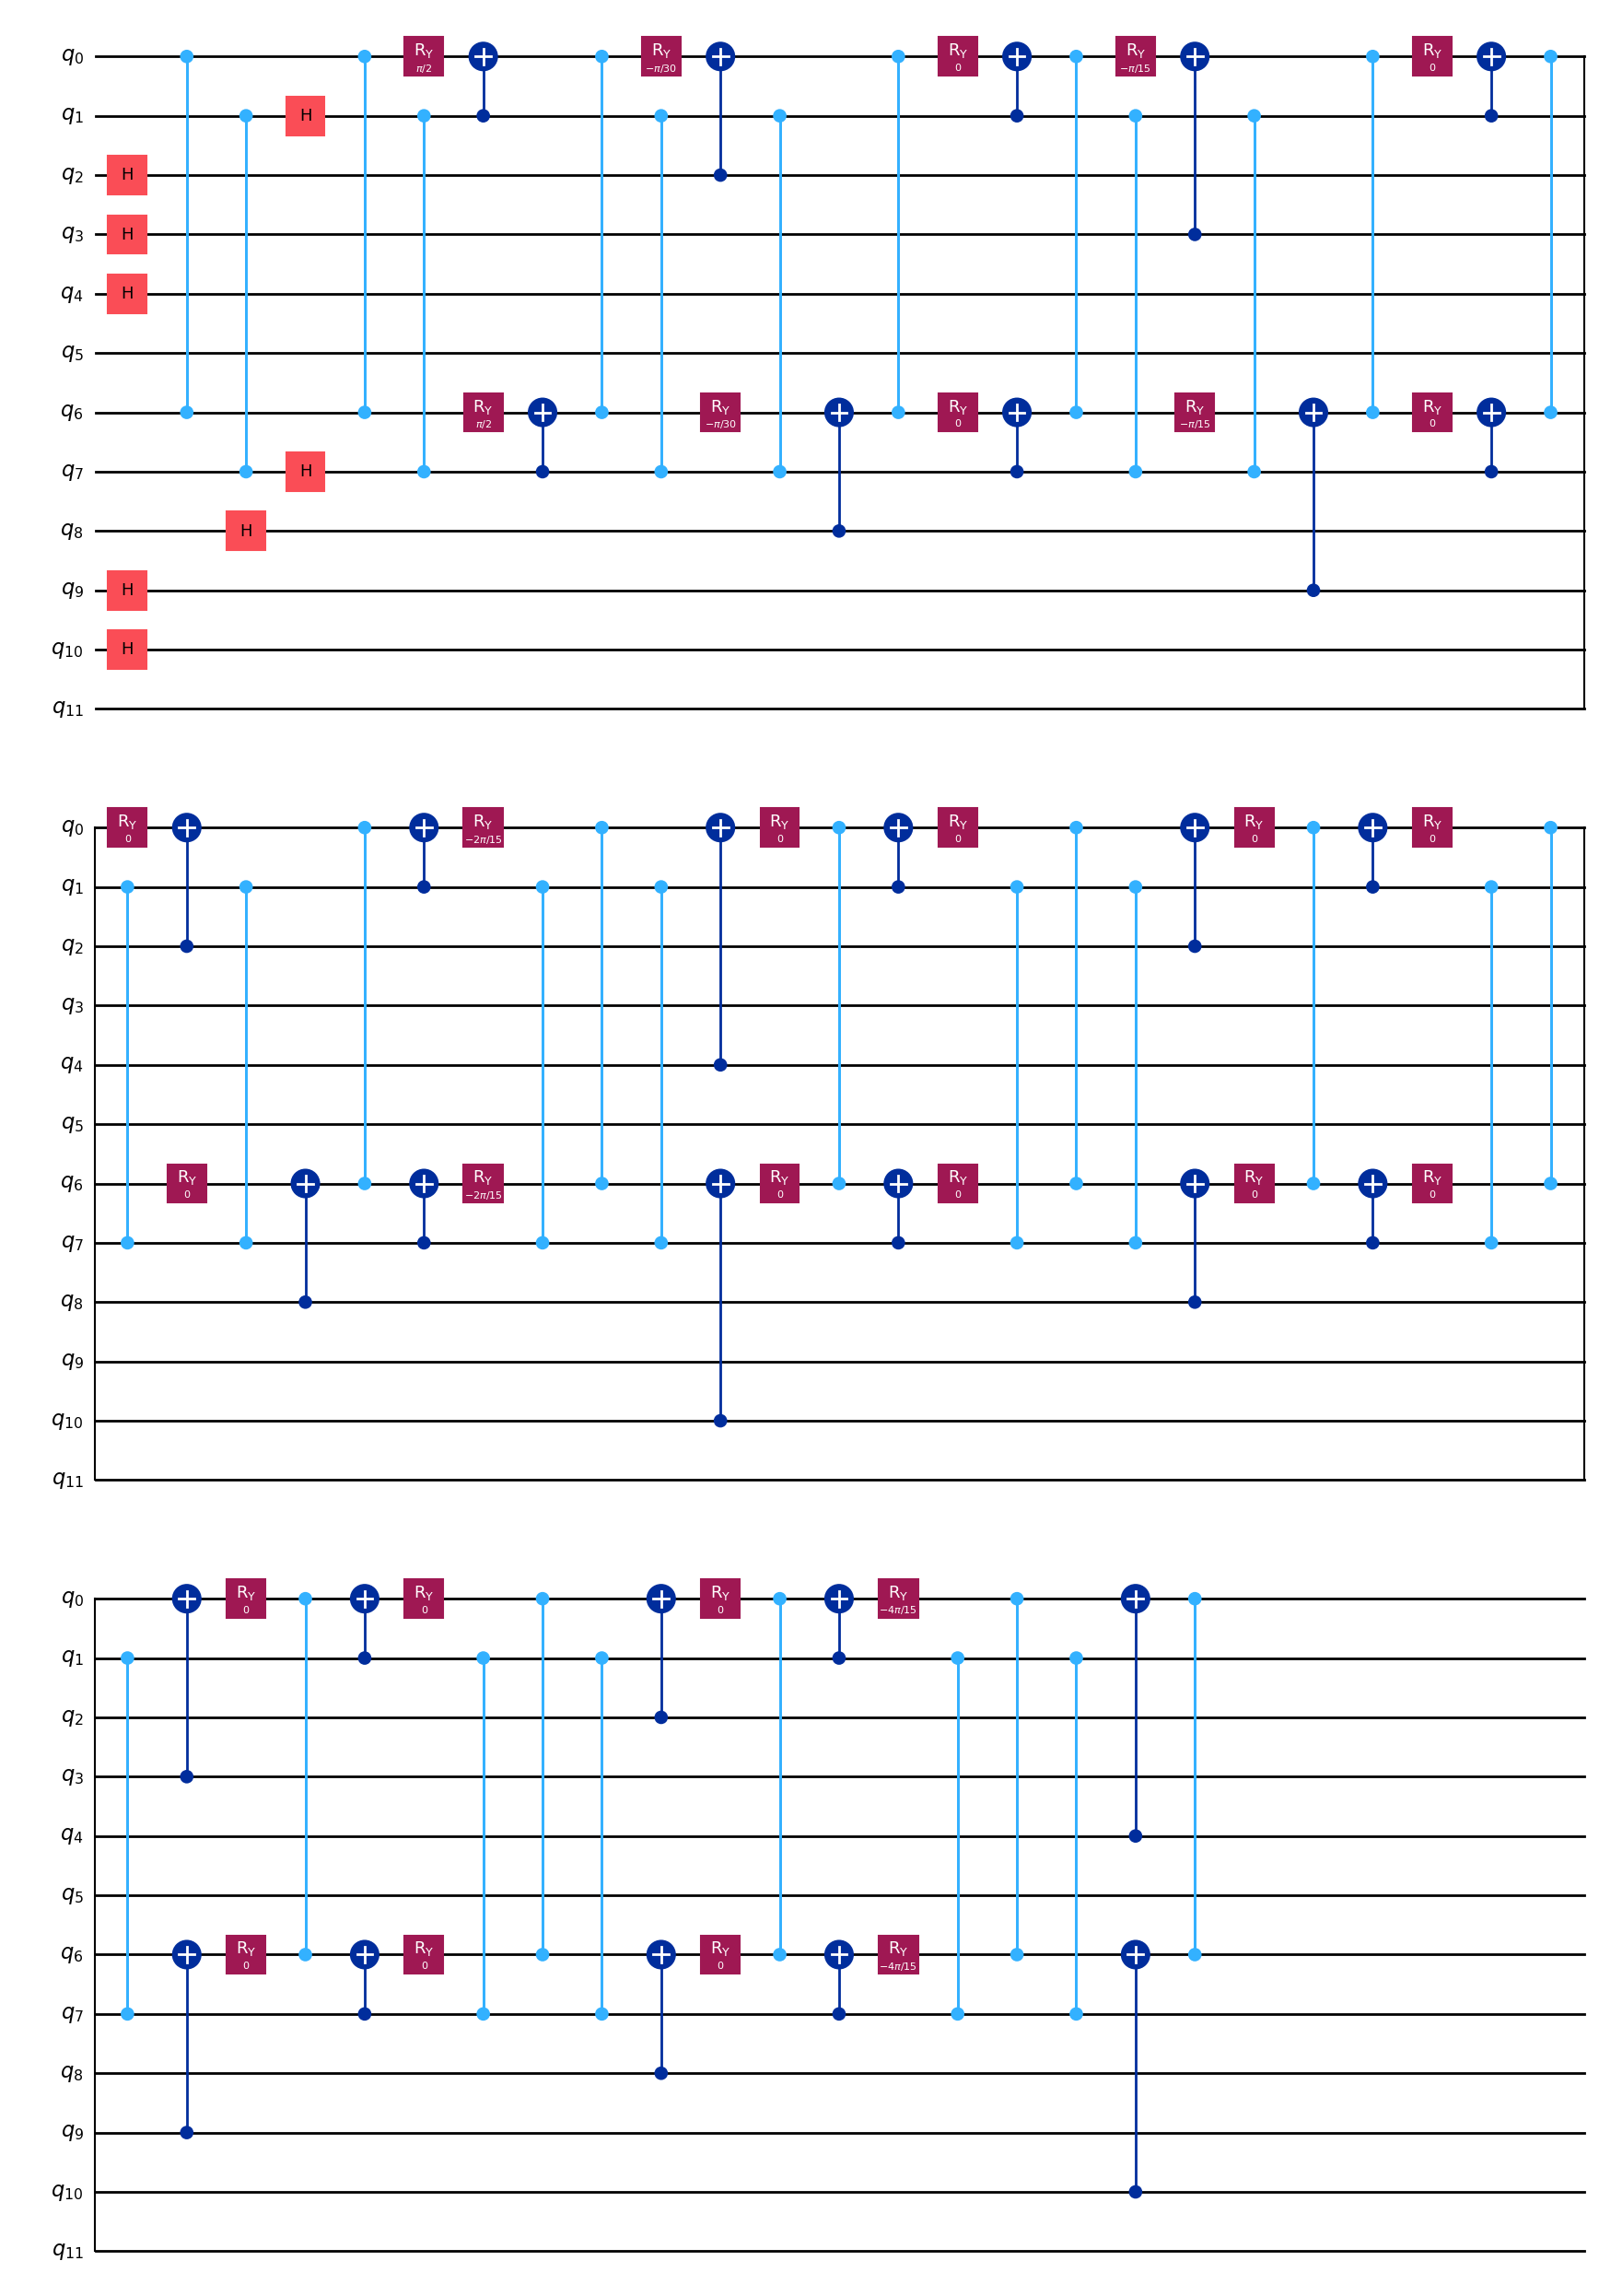

In [9]:
# === TEST: Dual QPIXL Slice Composition — No Ghost Qubits ===

from QPIXL.qiskit.qpixl_module import QPIXLModule
from QPIXL.qiskit.quantum_composer import QiskitCircuitModule, QuantumComposer
from IPython.display import display
import numpy as np

# Step 1: Prepare 16-angle QPIXL data
image_data = np.linspace(0, np.pi / 2, 16)

# Step 2: Create two QPIXL modules (data + algo)
qpixl_mod_data = QPIXLModule(image_data, name="QPIXLDATA_1")
qpixl_mod_algo = QPIXLModule(image_data, name="QPIXLDATA_2")
algo_mod = QiskitCircuitModule(qpixl_mod_algo.get_circuit(), name="QPIXLDATA_2_ALGO")

# Step 3: Compose with slice rule + CZ, ensure even slicing
composer = QuantumComposer([qpixl_mod_data, algo_mod])
combined = composer.combine(
    rule="slice",
    slice_size=2,
    connection_rule="cz",
    connection_map=[(0, 0), (1, 1)]  # connect first 2 qubits from each
)

# Step 4: Validate output
print(f"[TEST] Qubits: {combined.num_qubits}")
print(f"[TEST] Gate Count: {combined.count_ops()}")
print(f"[TEST] Registers: {[reg.name for reg in combined.qregs]}")

# Assert: Single register used, no ghost registers like q_5, q_11 etc.
assert len(combined.qregs) == 1, "❌ Ghost register detected!"
assert all(isinstance(q, qiskit.circuit.Qubit) for q in combined.qubits), "❌ Invalid qubits found"

# Display final circuit
display(combined.draw("mpl"))
